In [1]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1

2022-11-25 23:17:35.525536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 23:17:35.930835: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 23:17:35.999558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 23:17:35.999597: I tensorflow/stream_executor/cuda/cudart_stub.cc:

Instructions for updating:
non-resource variables are not supported in the long term


2022-11-25 23:17:39.831447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-25 23:17:39.832012: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-25 23:17:39.832084: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (diganta-HP-Laptop-14s-dy2xxx): /proc/driver/nvidia/version does not exist


Compiling model...
Building feed-forward neural network...
'build' took 0.090941 s



/home/diganta/anaconda3/envs/ML/lib/python3.8/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.738531 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.40e-01, 2.85e-02, 2.13e-01]    [1.40e-01, 2.85e-02, 2.13e-01]    []  
1000      [1.14e-04, 1.17e-04, 2.02e-01]    [9.95e-05, 1.17e-04, 2.02e-01]    []  
2000      [2.67e-03, 1.91e-05, 1.77e-01]    [1.13e-03, 1.91e-05, 1.77e-01]    []  
3000      [3.82e-03, 4.79e-06, 1.44e-01]    [3.32e-03, 4.79e-06, 1.44e-01]    []  
4000      [3.92e-03, 3.44e-06, 1.18e-01]    [9.44e-03, 3.44e-06, 1.18e-01]    []  
5000      [4.25e-03, 3.26e-06, 1.09e-01]    [1.64e-02, 3.26e-06, 1.09e-01]    []  
6000      [4.27e-03, 2.32e-06, 1.05e-01]    [1.48e-02, 2.32e-06, 1.05e-01]    []  
7000      [4.08e-03, 2.68e-06, 1.01e-01]    [1.26e-02, 2.68e-06, 1.01e-01]    []  
8000      [3.65e-03, 3.20e-06, 9.81e-02]    [1.29e-02, 3.20e-06, 9.81e-02]    []  
9000      [2.84e-03, 2.68e-06, 9.50e-02]    [1.99e-02, 2.68e-06, 9.50e-02]    []  
10000   

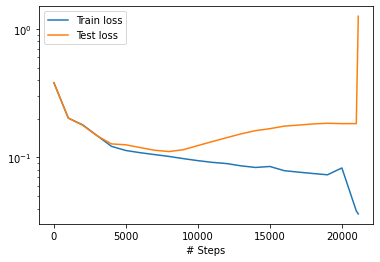

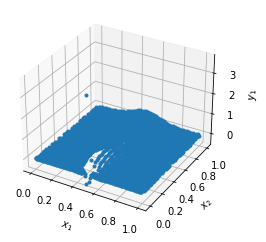

In [16]:
# Problem parameters:
a = 0.008 # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):



def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.exp(-(x[:, 0:1]-L/2)**2/(2*0.003**2))/(25*0.003*np.sqrt(2*np.pi)),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state,  isplot=True)

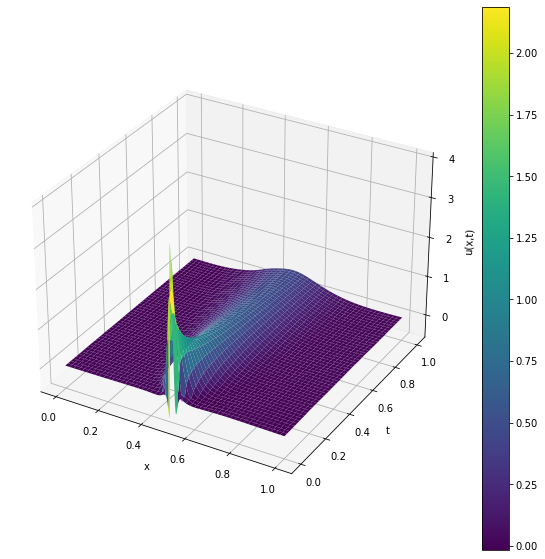

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
t=np.linspace(0.0,1.0,1000)
x=np.linspace(0,L,1000)
xx, tt = np.meshgrid(x, t)
#X = np.vstack((np.ravel(xx), np.ravel(tt))).T
#y_pred = model.predict(X)
#f = model.predict(X)
X=np.concatenate([xx.reshape(1000,1000,1),tt.reshape(1000,1000,1)],axis=2)
fig, ax = plt.subplots(nrows=1,ncols=1,subplot_kw={"projection": "3d"},figsize=(10,10))
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x,t)")
f1 = model.predict(X.reshape((1000000,2)))
s = ax.plot_surface(xx,tt,f1.reshape(1000,1000),cmap=cm.viridis)
fig.colorbar(s, ax=ax)

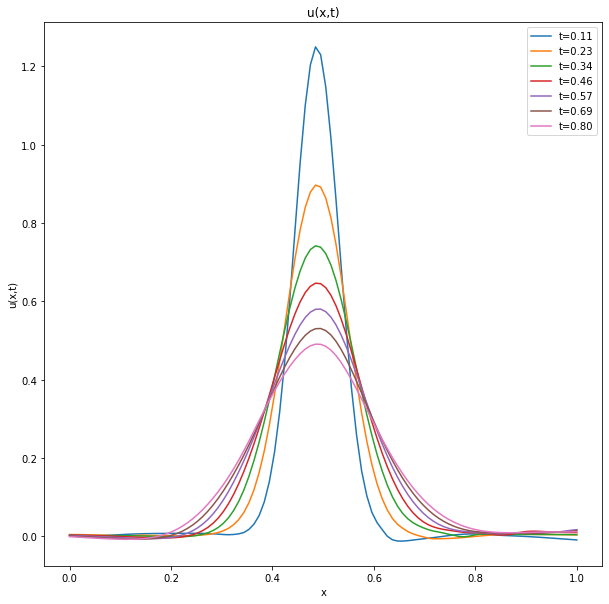

In [26]:
number_of_plots = 8
t1 = np.linspace(0,0.8,number_of_plots)

plt.figure(figsize=(10,10))
x = np.linspace(0,1,100)
#fig,axes = plt.subplots(number_of_plots,figsize=(6,number_of_plots*6))
for i in range(number_of_plots):
    if i!=0:
        t = t1[i] * np.ones_like(x)
        X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
        z = model.predict(X_T)
        plt.plot(x,z,label="t=%.2f"%(t1[i]))
    """else:
        z=np.exp(-(x-L/2)**2/(2*0.003**2))/(25*0.003*np.sqrt(2*np.pi))
        plt.plot(x,z,label="t=0.00")"""

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("u(x,t)")
plt.legend()

Text(0, 0.5, 't')

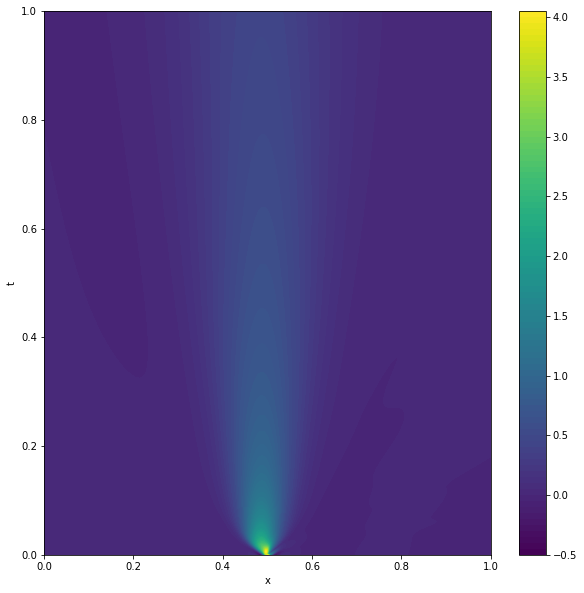

In [23]:
fig = plt.figure(figsize=(10,10))
u = plt.contourf(xx,tt,f1.reshape(1000,1000),100)
fig.colorbar(u)
plt.xlabel("x")
plt.ylabel("t(s)")